# 딥 러닝
## 3-1 뉴럴 네트워크를 활용한 분류
### 3-1-1 분류란?
`분류`란 여러 특징 데이터를 기반으로 `클래스(데이터의 종류)`를 예측하는 과제로, 예측하려는 클래스가 2개면 binary classification, 여러개면 multi-class classification으로 부른다. 이번 샘플에서는 MNIST 데이터셋을 활용해 손으로 쓴 숫자 이미지를 0~9로 분류한다.
### 3-1-2 숫자 데이터셋 'MNIST'
훈련 데이터 60,000건, 테스트 데이터 10,000건이 포함되어 있으며, 이미지는 gray scale로 28X28 픽셀 사이즈다.

### 3-1-3 패키지 임포트
패키지를 이용하기 위해서 pip command를 설치한 후, import로 노트북에서 이용하는 컴포넌트(클래스, 함수, 상수 등)을 지정해야 한다. <br>
가장 마지막의 `%matplotlib inline`은 노트북에서 그래프를 표시하는 명령이다. 

In [2]:
#패키지 임포트
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### 3-1-4 데이터셋 준비 및 확인
- 데이터셋 준비

```python
mnist.load_data()
```
를 이용해 데이터셋 MNIST를 네 가지 배열로 읽어 들인다. 이 배열은 파이썬의 배열 타입이 아닌 Numpy의 배열 타입인 ndarray이다. Numpy의 배열 타입을 사용하기 때문에 고속으로 배열 연산을 할 수 있다.

- 데이터셋 형태 확인

데이터셋의 형태(shape)를 확인한다. ndarray의 shape로 배열의 차원 수를 얻을 수 있다.

- 데이터셋 이미지 확인

matplotlib이라는 그래프 표시용 패키지를 이용하여 가장 처음 10건의 훈련 이미지를 확인한다.
```python
plt.subplot() # subplot(nrows, ncols, index) : 서브 플롯 추가, 인수는 행/열의 수와 플롯 위치
```
을 이용해 서브 플롯을 생성하고 다양한 그래프를 표시한다.
```python
plt.imshow() # imshow(X, cmap=None) : 이미지 표시, 인수는 이미지와 컬러 맵
```
을 이용해 이미지를 표시한다.

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


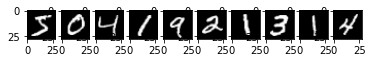

[5 0 4 1 9 2 1 3 1 4]


In [20]:
# 데이터셋 준비
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# 데이터셋 형태 확인
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

# 데이터셋 이미지 확인
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(train_images[i], 'gray')
plt.show()

# 데이터셋 라벨 확인
print(train_labels[0:10])

### 3-1-5 데이터셋 전처리 및 확인
학습을 시작하기 전에 데이터셋을 뉴럴 네트워크에 적합한 형태로 전환해야 한다. 이 과정을 '전처리'라고 부른다.
- 데이터셋 이미지 전처리

훈련 이미지와 테스트 이미지의 배열 엘리먼트인 이미지를 2차원 배열(28X28)에서 1차원 배열(784)로 변환한다. 이후의 뉴럴 네트워크는 1차원 엘리먼트를 입력받기 때문이다. <br>
ndarray의 차원 수를 변환하려면 reshape()를 사용한다. (tuple type의 shape를 parameter로 받는다.)

- 데이터셋 라벨 전처리

훈련 라벨과 테스트 라벨의 배열 엘리먼트 라벨은 one-hot encoding으로 변환한다. 어떤 엘리먼트의 값만이 1이고, 다른 엘리먼트의 값은 0인 표현 방식이다. 보통 분류 결과를 출력하는데 사용한다. 추론 시에 예상치가 가장 높은 것을 예측 결과로 한다. 숫자를 원-핫 인코딩으로 변환하려면 
```python 
to_categorical()
```
을 활용한다.

In [21]:
# 데이터셋 이미지 전처리
train_images = train_images.reshape((train_images.shape[0], 784))
test_images = test_images.reshape((test_images.shape[0], 784))

# 데이터셋 이미지 전처리 후 차원 확인
print(train_images.shape)
print(test_images.shape)

# 데이터셋 라벨 전처리
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

# 데이터셋 라벨 전처리 후 형태 확인
print(train_labels.shape)
print(test_labels.shape)

(60000, 784)
(10000, 784)
(60000, 10)
(10000, 10)


### 3-1-6 모델 생성
- 모델의 네트워크 구조

전결합 레이어(Fully-Connected layer, FC Layer) 3개를 쌓은 간단한 모델을 만든다. 각 유닛이 다음 레이어의 모든 유닛과 결합된 레이어이다.

- 입력 레이어 / 출력 레이어 / 히든 레이어

최초의 전결합 레이어가 '입력 레이어', 가장 마지막의 전결합 레이어가 '출력 레이어', 중간의 레이어가 '히든 레이어'다. <br>
일반적으로 레이어와 유닛의 수를 늘릴수록 복잡한 특징을 잡아낼 수 있지만, 그만큼 시간이 걸릴 수 있고, 중요성이 낮은 특징을 추출해 과적합(overfitting)이 되기 쉽다.

- 드롭아웃

Dropout은 과적합을 방지해 모델의 정밀도를 높이기 위한 방법 중 하나로, 임의의 레이어의 유닛을 랜덤으로 무효화하여 범용성(generalizability)을 높인다. 특정 뉴런의 존재에 대한 의존성을 낮춘다.

- 활성화 함수
Activation function은 레이어 다음에 적용하는 함수로, 레이어의 출력을 특정한 함수에 통과시킨 후, 최종 출력값을 결정한다. 이를 이용하여 선형적으로 분류할 수 없는 데이터도 분류할 수 있어서 보다 복잡한 특징을 잡아낼 수 있다.

> sigmoid : 출력이 0~1에 수렴함, 2 클래스 분류에 주로 사용되며, 입력 0에 대해 출력이 항상 양의 값이라 학습 효율이 좋지 않다. <br>
$f(x) = \frac{1}{1 + e^{-x}}$

> tanh : 출력이 -1~1에 수렴함, 중심점이 0이다. <br>

> ReLU : $f(x) = max(x, 0)$ backpropagation의 계산이 간단해 지며, gradient vanishing 문제를 해결한다. conv layer에서 많이 사용한다. <br>

> softmax : 다중 클래스 분류에서 많이 사용하는 활성화 함수이며, 입력 총 합계값이 1이 되도록 결과를 출력한다.
$$f(x)_i = \frac{e^{x_i}}{\sum_{k=1}^{n}e^{x_k}} \forall i=1,...,n$$


- 모델 생성
`Sequential`을 생성하고, `add()`로 레이어와 Dropout을 추가한다.

In [22]:
# 모델 생성
model = Sequential()
model.add(Dense(256, activation='sigmoid', input_shape=(784, ))) # 입력 레이어
model.add(Dense(128, activation='sigmoid')) # 히든 레이어
model.add(Dropout(rate=0.5)) # 드롭아웃
model.add(Dense(10, activation='softmax')) # 출력 레이어

### 3-1-7 컴파일
- 손실 함수

Loss function은 모델의 예측값과 정답 데이터 사이의 오차를 계산하는 함수다. 이 오차에 기반해 이후에 설명할 최적화 함수에서 손실 함수의 결과가 0에 가까워지도록 가중치 파라미터와 바이어스를 최적화한다.
> 주요 오차 함수
> 1. binary_crossentropy : 이진 클래스 교차 엔트로피 오차
> 2. categorical_crossentropy : 다중 클래스 교차 엔트로피 오차
> 3. mse : 평균 제곱 오차

- 최적화 함수

Optimizer는 손실 함수의 결과가 0에 가까워지도록 가중치 파라미터와 바이어스를 최적화하는 함수다. 미분으로 구한 값을 학습률, epoch(훈련 데이터를 한 차례 전부 사용) 수, 과거의 가중치 갱신량 등을 고려하여 얼마의 가중치를 반영해 갱신할 지 결정한다.
> 주요 최적화 함수
> 1. SGD (Stochastic Gradient Descent)
> 2. Adam

- 평가 지표

Evaluation Metric은 모델의 성능을 측정하기 위해 사용되는 지표다. 측정 결과는 학습을 수행하는 fit()의 반환값으로 저장되고 클래스 등에서 표시한다.
> 주요 평가 지표
> 1. acc (Accuracy) : 정답률, 분류에서 이용한다.
> 2. mae (Mean Absolute Error) : 평균 절대 오차, 회귀에서 이용한다.

- 컴파일

손실함수를 'categorical_crossentropy', 최적화 함수는 'SGD', 학습률은 0.1, 평가 지표는 'acc'를 이용한다. <br>
Learning rate은 각 레이어의 가중치를 일정하게 얼마만큼 변경할지 결정하는 값이다.

In [23]:
# 컴파일
model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.1), metrics=['acc'])

### 3-1-8 학습
훈련 이미지와 훈련 라벨의 배열을 모델에 전달해 학습을 수행한다. `model.fit()`을 사용해 학습을 시작한다. <br>
- `ndarray` 타입의 훈련 데이터, 훈련 라벨을 앞의 두 parameter에 넣는다.
- `batch_size` 는 훈련 데이터의 엘리먼트를 몇개 단위로 훈련시킬지 결정한다. 클수록 학습 속도가 빠르나, 메모리 소비량도 증가한다.
- `validation_split` 은 훈련 데이터 중 검증 데이터로 사용할 데이터의 비율을 의미하며 검증 데이터는 훈련 데이터의 일부분을 분리해 훈련에 이용하지 않고 검증하는데만 사용한다.

In [24]:
# 학습
history = model.fit(train_images, train_labels, batch_size=500, epochs=5, validation_split=0.2)

Epoch 1/5
96/96 [==============================] - 1s 4ms/step - loss: 1.6852 - acc: 0.4501 - val_loss: 0.9671 - val_acc: 0.8320
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9240 - acc: 0.7404 - val_loss: 0.5838 - val_acc: 0.8803
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.6650 - acc: 0.8151 - val_loss: 0.4435 - val_acc: 0.8987
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.5458 - acc: 0.8481 - val_loss: 0.3725 - val_acc: 0.9067
Epoch 5/5
96/96 [==============================] - 0s 3ms/step - loss: 0.4793 - acc: 0.8674 - val_loss: 0.3286 - val_acc: 0.9133


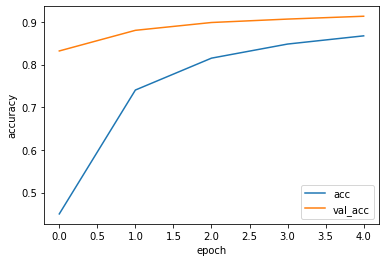

In [28]:
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='best') # 가장 적합한 위치에 라벨 설명 표시
plt.show()

### 3-1-9 그래프 표시 & 3-1-10 평가
테스트 이미지와 테스트 라벨의 배열을 모델에 전달해 평가를 실행하고, 정답률을 확인한다. `model.evaluate()`를 이용한다.

In [29]:
# 평가
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('loss : {:.3f}\nacc: {:.3f}'.format(test_loss, test_acc))

313/313 [==============================] - 0s 995us/step - loss: 0.3328 - acc: 0.9143
loss : 0.333
acc: 0.914


### 3-1-11 추론
첫 데이터 10건의 테스트 이미지 추론을 수행해 예측 결과를 얻는다. `model.predict()`를 사용한다. <br>
변환값은 이미지별로 '원-핫 인코딩 형식'으로 반환한다. 이를 `np.argmax()`을 이용해 최댓값의 인덱스로 변환한다.

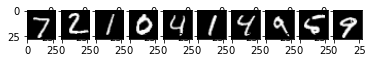

[7 2 1 0 4 1 4 9 6 9]


In [30]:
# 추론할 이미지 표시
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(test_images[i].reshape((28, 28)), 'gray')
plt.show()

# 추론할 라벨 표시
test_predictions = model.predict(test_images[0:10]) # 입력 데이터 ndarray를 받아 ndarray 예측값을 return 한다.
test_predictions = np.argmax(test_predictions, axis=1) #ndarray 배열과 최댓값을 읽을 축의 방향을 받아 ndarray 또는 int의 인덱스를 return 한다.
print(test_predictions)